In [129]:
import shapely as shp
from shapely.geometry import LineString, MultiPolygon, MultiLineString, LinearRing, Point, Polygon
from shapely.ops import linemerge,polygonize
import geopandas as gpd
import numpy as np

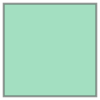

In [132]:
grid_gdf=gpd.read_parquet('/home/pedro/Documents/GIT_WORKSPACE/split_offdb/inputs/grid.parquet')
unidade_split = grid_gdf[grid_gdf["grid_id"] == 24].geometry.values[0]
unidade_split

In [133]:
input_gdf=gpd.read_parquet('/home/pedro/Documents/GIT_WORKSPACE/split_offdb/inputs/input.parquet')
input_gdf.head()

,id,id_layer,geom
0,56285,CAR,"MULTIPOLYGON (((-36.73056 -9.49319, -36.72995 ..."
1,56286,CAR,"MULTIPOLYGON (((-36.73972 -9.49228, -36.73828 ..."
2,56287,CAR,"MULTIPOLYGON (((-36.73341 -9.49867, -36.7327 -..."
3,56894,CAR,"MULTIPOLYGON (((-36.65406 -9.59078, -36.65379 ..."
4,58371,CAR,"MULTIPOLYGON (((-37.50167 -9.29629, -37.5036 -..."


In [145]:
# Cria um índice espacial para `input_gdf`
input_sindex = input_gdf.sindex

# Filtra apenas as geometrias que têm bbox sobrepondo `unidade_split`
possible_matches_index = list(input_sindex.intersection(unidade_split.bounds))
possible_matches = input_gdf.iloc[possible_matches_index]
possible_matches.reset_index(inplace=True)
possible_matches['geom'][0].bounds

(-36.49894133, -9.50444, -36.49744226, -9.49749882)

In [135]:
intersections=[]
intersecting_ids=[]
# Filtra apenas as interseções reais
for index, row in possible_matches.iterrows():
    geom=row.geom
    if isinstance(geom, Polygon):
        geom=geom
    elif isinstance(geom, MultiPolygon):
        geom=geom.geoms[0]


        
    if geom.is_valid:
        intersection = unidade_split.intersection(geom)
        if isinstance(intersection, Polygon):
            intersection=intersection
        elif isinstance(intersection, MultiPolygon):
            intersection=intersection.geoms[0]

    else:
        print('Eliminando geometria inválida')

    
    # Checa se a interseção é válida e não está vazia
    if not intersection.is_empty and intersection.is_valid:
        intersections.append(intersection)
        intersecting_ids.append(row['id'])  # Armazena o 'id' da geometria original
    else:
        print('Eliminando geometria inválida ou vazia')


gdf_input_intersection = gpd.GeoDataFrame(
    data={'id': intersecting_ids, 'geom': intersections},  # Inclui o ID original da geometria que intersectou
    geometry='geom',
    crs='EPSG:4674')

polys=[geom for geom in gdf_input_intersection.geom]


Eliminando geometria inválida
Eliminando geometria inválida
Eliminando geometria inválida
Eliminando geometria inválida


In [137]:
gdf_input_intersection.to_parquet('/home/pedro/Documents/GIT_WORKSPACE/split_offdb/dev/grid_24_al.parquet')